<a href="https://colab.research.google.com/github/isi-e/ml_nat/blob/main/ex_11_GM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Sheet No. 11

---

> Machine Learning for Natural Sciences, Summer 2024, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
>
> Deadline: 28.07.2025, 8 am
>
> Tutor: jona.oestreicher@kit.edu
> **Please ask questions in the forum and only contact the Tutor when there are issues with the grading**

---
**Topic**: This exercise sheet will introduce you to generative models in machine learning.

Please add here your group members' names and student IDs.

Names: Isabella Mebus Kishi de Oliveira

IDs: utmce


# Variational AutoEncoders

In this exercise we will work on Variational AutoEncoders, first introduced by Welling and Kingma in a popular paper published in 2014 (https://arxiv.org/pdf/1312.6114.pdf).
We will implement a vanilla version of a VAE, with encoder and decoder composed of fully connected layers only, and try to use it for an anomaly detection task. We will then see how we can impose nice properties on the latent representation of data produced by the network simply augmenting it with a linear regressor.

In [1]:
##### DO NOT CHANGE #####
%pip install lightning
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from numpy.typing import NDArray
from lightning.pytorch import LightningDataModule
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import train_test_split
from lightning import LightningModule
from matplotlib.axes import Axes
from torchmetrics import MeanMetric, MetricCollection
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import CSVLogger
from pathlib import Path
from functools import reduce
import seaborn as sns


def nextcloud_download(url: str, raw: bool = False) -> str:
    """
    Downloads the content of a file from a nextcloud server and returns
    it eithers as a string or a bytes object if the ``raw`` flag is set.
    """
    response = requests.get(f"{url}/download")
    content = response.content
    if not raw:
        content = content.decode("utf-8")

    return content


##### DO NOT CHANGE #####

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 0. Getting to know the electrocardiogram (ECG) Dataset

The data we will work with consists of segments of electrocardiograms (ECGs) of healthy patients and patients suffering from premature ventricular contraction (PVC).

In the next cells we will define a custom `torch.utils.data.Dataset` class that will serve as the general interface between our models and the data. In addition we define a `lightning.pytorch.LightningDataModule` class that helps us loading the data from the cloud and with applying some preprocessing steps.
One these of steps is for example to cut or pad the segments to a fixed `feature lenght` of `350`. The `lightning.pytorch.LightningDataModule` also defines `train/val/test_dataloader` methods which will be used during training by the `lightning.pytorch.Trainer` later.

In [2]:
##### DO NOT CHANGE #####
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, x: NDArray, y: NDArray):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[idx], self.y[idx]

##### DO NOT CHANGE #####

In [3]:
##### DO NOT CHANGE #####
np.random.seed(66)
torch.manual_seed(66)
NUM_EPOCHS = 100


class ECGDataModule(LightningDataModule):
    def __init__(
        self,
        batch_size: int = 128,
        feature_length: int = 350,
        filter_size: int = 5,
        composed: bool = False,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.feature_length = feature_length
        self.filter_size = filter_size
        self.composed = composed

        self.prepare_data()
        # These will be set in setup()
        self.train_data = None
        self.val_data = None
        self.test_data = None

    def prepare_data(self) -> None:
        content = nextcloud_download(
            "https://bwsyncandshare.kit.edu/s/CP7z4JTsRi3JqZm", raw=True
        )
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            tmp.write(content)
            tmp_path = tmp.name
        data = pd.read_hdf(tmp_path)
        data = data[data["label"].isin(["Normal", "PVC"])]
        data = data.drop(columns=["length"], errors="ignore")
        self.df = data

    def setup(self, stage: str | None = None) -> None:
        df = self.df.copy()

        if self.composed:
            # Composed mode: Train and validate on both Normal and PVC
            features = df.iloc[:, : self.feature_length].values
            max_val = np.max(np.abs(features))
            features /= max_val
            features = uniform_filter1d(features, size=self.filter_size)

            labels = df["label"].astype("category").cat.codes.values
            X_train, X_val, y_train, y_val = train_test_split(
                features, labels, test_size=0.1
            )

            self.train_data = ECGDataset(X_train, y_train)
            self.val_data = ECGDataset(X_val, y_val)
            self.test_data = ECGDataset(X_val, y_val)  # Placeholder
            return

        # Non-composed mode: Train/val on Normal, test on PVC + some Normal
        normal_df = df[df["label"] == "Normal"]
        pvc_df = df[df["label"] == "PVC"]

        norm_feat = normal_df.iloc[:, : self.feature_length].values
        max_val = np.max(np.abs(norm_feat))
        norm_feat = uniform_filter1d(norm_feat / max_val, size=self.filter_size)

        X_train, X_val = train_test_split(norm_feat, test_size=0.2)
        y_train = np.zeros(len(X_train))
        y_val = np.zeros(len(X_val))

        pvc_feat = pvc_df.iloc[:, : self.feature_length].values
        pvc_feat = uniform_filter1d(pvc_feat / max_val, size=self.filter_size)
        _, X_test_pvc = train_test_split(pvc_feat, test_size=0.1)
        y_test_pvc = np.ones(len(X_test_pvc))

        # Add 650 "Normal" validation examples to test
        X_test = np.concatenate((X_test_pvc, X_val[:650]))
        y_test = np.concatenate((y_test_pvc, y_val[:650]))

        # Remaining val
        X_val = X_val[650:]
        y_val = y_val[650:]

        self.train_data = ECGDataset(X_train, y_train)
        self.val_data = ECGDataset(X_val, y_val)
        self.test_data = ECGDataset(X_test, y_test)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

    def visualize(self, num_samples: int = 5) -> None:
        fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 6))
        df = self.df[self.df["label"].isin(["Normal", "PVC"])]
        normal = df[df["label"] == "Normal"].sample(num_samples)
        pvc = df[df["label"] == "PVC"].sample(num_samples)

        for i in range(num_samples):
            axes[0, i].plot(normal.iloc[i, : self.feature_length])
            axes[1, i].plot(pvc.iloc[i, : self.feature_length])

        axes[0, 0].set_ylabel("Normal")
        axes[1, 0].set_ylabel("PVC")
        plt.tight_layout()
        plt.show()


DATA_MODULE = ECGDataModule()
DATA_MODULE.setup()

##### DO NOT CHANGE #####

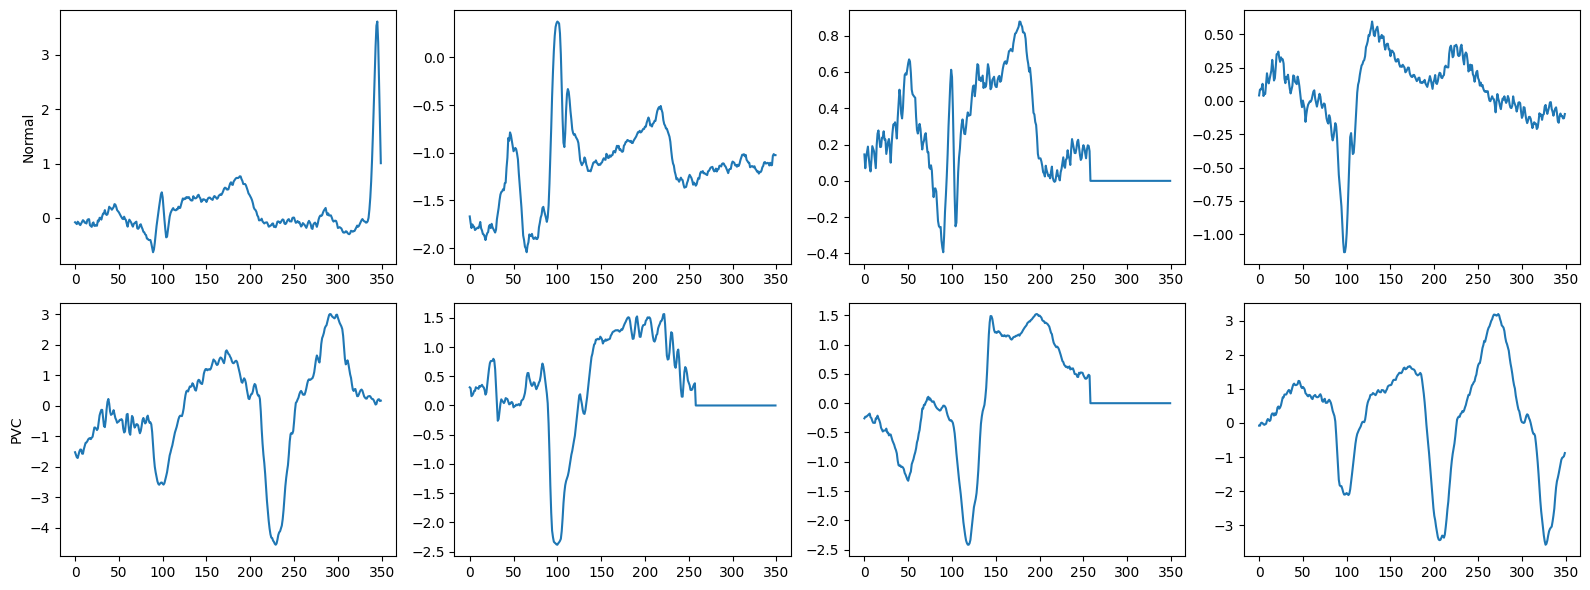

In [4]:
##### DO NOT CHANGE #####
DATA_MODULE.visualize(num_samples=4)

##### DO NOT CHANGE #####

# 1. Implementing an anomalous hearbeat detector

In the first part of the exercise we will implement a detector for anomalous hearbeats, thus our `training` and `validation` sets will consist of `normal` heartbeats only while in the `test` set we will have `both` `normal` and `PVC` ECGs.


An autoencoder is an unsupervised representation learning algorithm based on neural networks that is used to learn efficient codings of unlabeled data. In particular, by imposing a bottleneck in the encoding layer of the network we can extract a compressed representation of the original input leveraging the structure present in it, i.e. the correlations among input features.

In an AE input data is converted into a deterministic encoding vector, i.e. for each of the latent features the encoder outputs a single value. VAEs are an extension of AE int the sense that instead of performing a single value estimation of the latent vector they produce a probabilistic distribution $q_{\phi}(z|x)$ in the latent space. This is done leveraging variational bayesian inference: an approximation of the distribution is picked from some tractable family and then this is made as close as possible to the true posterior. In particular in the original formulation of VAE the prior imposed on the latent representation is a standard Gaussian and the mean field approximation is used, i.e. the latent variables are considered as independent from each other.

Being the latent representation of our data a probabilistic distribution, to reconstruct input data we have to sample points from it $z$~$q_{\phi}(z|x)$. The fact that one of the nodes in the computational graph is a random node would create a problem in the backpropagation step because the gradient would not be able to 'flow' through it.

One of the key elements in the VAE architecture is the so called 'reparameterization trick', that allow us to express a distribution $q_{\phi}(z|x)$ as a two-step generative process:
1. sample a noise variable $\epsilon$ from a simple distribution:
2. apply a deterministic transformation $g_{\phi}(\epsilon,x)$ that maps the random noise into a more complex distribution.


In the case of Gaussian distributions the reparametrization trick is particularly simple: instead of writing $z$∼$q_{\phi}(z|x)=\mathcal{N}(\mu_{\phi}, \Sigma_{\phi})$ we can just write $z=g_{\phi}(\epsilon, x)= \mu_{\phi} +  \sigma_{\phi}*\epsilon$,  where $\epsilon$ is a vector of iid variables $\epsilon_{i}$∼$\mathcal{N}(0,1)$ and $*$ is the Hadamard product, and then backpropagate the gradient through $\mu_{\phi}$ and $\sigma_{\phi}$, as shown in the following picture:


<br>

<img src="https://bwsyncandshare.kit.edu/s/tREreFEeLmL5ecz/download" style="width: 500px;">

## 1.1 Task: Complete the VAE Model class

In the following a partial implementation of a simple VAE with MLPs as encoder and decoder is provided. `Complete the functions`, paying attention to the fact that the encoder has to produce the logarithm of the standard deviation of each of the latent variables (this is done to ensure that the standard deviation is always positive).

Hint: torch has a function similar to numpy.random.randn

In [5]:
class VAE(nn.Module):
    def __init__(
        self,
        input_dim: int = 350,
        embedding_dim: int = 30,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim

        self._backbone = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.4),
        )
        self._fc_mean = nn.Linear(500, embedding_dim)
        self._fc_logstd = nn.Sequential(
            nn.Linear(500, embedding_dim),
            nn.LeakyReLU(negative_slope=0.05),
        )

        self._decoder = nn.Sequential(
            nn.Linear(embedding_dim, 500),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.4),
            nn.Linear(500, input_dim),
        )

    def encode(self, x: torch.Tensor):
        """
        The encoder is composed of a first fully connected layer followed by
        two parallel linear layers that generate independently the mean and logstd of the latent distribution
        """
        temp = self._backbone(x)
        mean = self._fc_mean(temp)
        logstd = self._fc_logstd(temp)
        # YOUR CODE HERE
        return mean, logstd

    def reparameterize(self, mean: torch.Tensor, logstd: torch.Tensor):
        """
        Once the latent distribution is computed from the input a latent vector has to be sampled from it.
        We are working on gaussians, look at the formula in the block above
        and remember that the encoder produces the logstd.
        """
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        z = mean + std * eps
        # YOUR CODE HERE
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self._decoder(z)

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        VAE computes the latent distribution associated with the input,
        samples a vector from it and finally decodes it.
        """
        mean, logstd = self.encode(x)
        z = self.reparameterize(mean, logstd)
        out = self.decode(z)
        # YOUR CODE HERE
        return out, mean, logstd, z

In [6]:
##### DO NOT CHANGE #####
# ID: VAE_correctly_implemented - possible points: 4

# Public_tests
def test_vae():
    vae = VAE(1, 2)
    m, s = vae.encode(torch.Tensor([1]))
    assert m.shape == s.shape and m.shape == torch.Size([2]), (
        "error in encodings dimension"
    )

    s = vae.reparameterize(torch.Tensor([0, 0]), torch.log(torch.tensor([1, 1])))
    assert s.size() == torch.Size([2]), "error in dimension of generated random vector"

    in_dim, emb_dim = torch.randint(1, 10, (2,))
    vae = VAE(in_dim, emb_dim)
    inp = torch.randn(in_dim)
    out, _, _, z = vae.forward(inp)
    assert inp.shape == out.shape, "input and output shape mismatch!"
    assert z.shape == torch.Size([emb_dim]), "latent vector has wrong dimension"


test_vae()


# Hidden test to check the VAE implementation

##### DO NOT CHANGE #####

## 1.2 Task: Defining the ELBO Loss function

What we want to maximize in variational Bayes methods is the ELBO, which stands for "evidence lower bound":

$
\begin{align}
ELBO(\theta, \phi) = [\mathbb{E}_{q_{\phi}(z)}[\log p_{\theta}(x, z) - \log q_{\phi}(z|x)] ] = \\
-KL[q_{\phi}(z|x)|| p_{\theta}(z)] + \frac{1}{L} \sum_{l=1}^{L} \log p_{\theta}(x|z^{(l)})
\end{align}
$

where $q_{\phi}(z|x)$ represents the encoder and $\log p_{\theta}(x|z^{(l)})$ is the loglikelihood of the reconstruction and depends on the decoder parameters. (Loglikelihood is a fancy term which in our case represent simply the reconstruction error. Take a look at Bayesian interpretations of loss functions (MSE is the easiest) if you are interested)

The KL (Kullback–Leibler) divergence is a measure of how similar two probability distributions are (if equal -> KL=0) and it is also known as relative entropy. Note that the KL divergence is not a distance metric since it is not symmetric.

The KL divergence of some families of distributions can be computed analytically and that's the case if we choose Gaussians priors and posteriors.

`Implement` the KL divergence between a Gaussian posterior $q_{\phi}(z|x) = \mathcal{N}(\mu, \Sigma)$, where $\Sigma = diag(\sigma_{j})$ with $j \in {1, ..., J}$, and a standard Gaussian prior $p(z) = \mathcal{N}(0, I)$ : &emsp; $-\frac{1}{2} \sum_{j=1}^{J} (1 + \log((\sigma_{j})^{2}) - (\mu_{j})^{2} - (\sigma_{j})^2)$

<br><br><br>

<img src="https://bwsyncandshare.kit.edu/s/2QwqARArsMtEQn7/download" style="width: 500px;">





In [9]:
def KL_normnorm(mean, logstd):
    """
    Implement the closed form of KL divergence for a gaussian N(mean, std) as posterior
    and a standard gaussian N(0, 1) as prior. Careful with the logarithm!
    """
    # The formula for KL divergence between N(mean, std) and N(0, 1) is:
    # -0.5 * sum(1 + log(std^2) - mean^2 - std^2)
    # Since we have logstd, log(std^2) = 2 * logstd
    std = torch.exp(logstd)
    kl = -0.5 * torch.sum(1 + 2 * logstd - mean**2 - std**2)
    # YOUR CODE HERE
    return kl

In [10]:
##### DO NOT CHANGE #####
# ID: kl_divergence - possible points: 2

# Public_tests
def test_KL_normnorm():
    mean = torch.randn(3)
    logstd = abs(torch.randn_like(mean))
    try:
        KL_normnorm(mean, logstd).item()
    except:
        print(
            "KL divergence of two probability distributions is a number, not a vector..."
        )


test_KL_normnorm()


# Hidden test that checks if the KL_normnorm gives correct values

##### DO NOT CHANGE #####

In [11]:
##### DO NOT CHANGE #####
class ELBOLoss(nn.Module):
    def __init__(self, kl_weight: float = 0.1):
        super().__init__()
        self.kl_weight = kl_weight
        self.reconstruction_loss = nn.L1Loss(reduction="none")

    def forward(
        self,
        x: torch.Tensor,
        out: torch.Tensor,
        mean: torch.Tensor,
        logstd: torch.Tensor,
        scaling: float = 1.0,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        reconstruction_error = self.reconstruction_loss(out, x).sum(-1)
        reconstruction_loss = reconstruction_error.sum() / x.size(0)
        kl_loss = KL_normnorm(mean, logstd) / x.size(0)
        elbo_loss = reconstruction_loss + kl_loss * self.kl_weight * scaling
        return elbo_loss, reconstruction_loss, kl_loss, reconstruction_error


##### DO NOT CHANGE #####

Differently from the original formulation of VAE we are going to multiply the KL divergence with a scalar parameter in such a way to regulate the tradeoff between the two terms of the ELBO loss (this is somehow similar to beta-VAE: https://openreview.net/references/pdf?id=Sy2fzU9gl). Then, as suggested in https://arxiv.org/pdf/1511.06349.pdf, we will initially set this parameter to zero and increase it linearly w.r.t. the number of epochs (this approach is termed KL warmup).

## 1.3 Definition of the Training and Testing Pipeline

From previous exercises you should be already familiar with the `pytorch lighning` framework. We will use this framework to clearly structure our training and evaluation process. The next cell defines a `LightningModule` that streamlines our training an testing pipeline. It seems like there is a lot going on, but luckily for you, you dont't have to change it.

In [13]:
##### DO NOT CHANGE #####
def plot_reconstructed(
    original: torch.Tensor,
    reconstructed: torch.Tensor,
    n_samples: int = 5,
):
    n_samples = min(n_samples, original.shape[0])
    fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples * 5, 2 * 5))
    for i in range(n_samples):
        axes[0][i].plot(original[i])
        axes[1][i].plot(reconstructed[i])

    axes[0][0].set_ylabel("Original")
    axes[1][0].set_ylabel("Reconstructed")


class VAELitModule(LightningModule):
    def __init__(
        self,
        metrics: MetricCollection,
    ):
        super().__init__()
        self.model = VAE(input_dim=350, embedding_dim=30)
        self.loss = ELBOLoss(kl_weight=0.1)

        self.train_metrics = metrics.clone(prefix="train/")
        self.val_metrics = metrics.clone(prefix="val/")

        self.train_reconstruction_errors = []
        self.test_reconstruction_errors = []
        self.test_labels = []

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.model(x)

    def _step(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        metrics: MetricCollection | None = None,
        reconstruction_errors: list | None = None,
        kl_scaling: float = 1.0,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x, y = batch
        out, mean, logstd, z = self(x)
        *loss_terms, reconstruction_error = total_loss, *_ = self.loss.forward(
            x, out, mean, logstd, scaling=kl_scaling
        )

        if metrics is not None:
            for loss, metric in zip(loss_terms, metrics.values()):
                metric.update(loss)

        if reconstruction_errors is not None:
            reconstruction_errors.append(reconstruction_error.detach().cpu())

        return total_loss, out

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        kl_scaling = self.current_epoch / self.trainer.max_epochs
        loss, _ = self._step(
            batch=batch,
            metrics=self.train_metrics,
            kl_scaling=kl_scaling,
        )
        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        loss, _ = self._step(
            batch=batch,
            metrics=self.val_metrics,
        )
        return loss

    def test_step(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        batch_idx: int,
        dataloader_idx: int = 0,
    ):
        x, y = batch

        if dataloader_idx == 0:
            reconstruction_errors = self.train_reconstruction_errors

        elif dataloader_idx == 1:
            reconstruction_errors = self.test_reconstruction_errors
            self.test_labels.append(y.detach().cpu())

        _, out = self._step(
            batch=batch,
            reconstruction_errors=reconstruction_errors,
        )
        if dataloader_idx == 1 and batch_idx == 0:
            plot_reconstructed(original=x, reconstructed=out, n_samples=3)

    def get_classification_threshold(self) -> None:
        reconstruction_errors = torch.cat(self.train_reconstruction_errors)
        self.threshold = torch.quantile(reconstruction_errors, 0.85).item()
        fig, ax = plt.subplots()
        ax.hist(reconstruction_errors.numpy(), bins=np.arange(0, 15, 0.125))
        ax.set_title("train")
        ax.axvline(x=self.threshold, c="red")

    def on_test_end(self):
        self.get_classification_threshold()
        reconstruction_errors = torch.cat(self.test_reconstruction_errors).numpy()
        labels = torch.cat(self.test_labels).numpy()

        outliers_error = reconstruction_errors[labels == 1]
        normal_error = reconstruction_errors[labels == 0]
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax1: Axes
        ax2: Axes

        ax1.hist(normal_error, bins=np.arange(0, 15, 0.125))
        ax1.set_title("normal")
        ax1.axvline(x=self.threshold, c="red")
        ax2.hist(outliers_error, bins=np.arange(0, 15, 0.125))
        ax2.set_title("anomalies")
        ax2.axvline(x=self.threshold, c="red")
        print(
            f" Avg reconstruction error \n \t normal data : {normal_error.mean()}, anomalies : {outliers_error.mean()}"
        )

        fig, ax = plt.subplots()
        predictions = (reconstruction_errors > self.threshold).astype(float)
        cm = confusion_matrix(labels, predictions, normalize="true")
        sns.heatmap(
            cm,
            square=True,
            xticklabels=["Normal", "PVC"],
            yticklabels=["Normal", "PVC"],
            annot=True,
            cbar=False,
            cmap="Reds",
            fmt=".2f",
        ).get_figure()
        ax.set_title("Anomaly detection: confusion matrix")

        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)
        f1 = f1_score(labels, predictions)

        print(
            f"Quality measures of our classifier:\n\t precision : {precision}\n\t recall : {recall}\n\t F1_score : {f1}"
        )

    def _on_epoch_end(self, metrics: MetricCollection):
        for metric_name, metric in metrics.items():
            self.log(metric_name, metric)

    def on_train_epoch_end(self):
        self._on_epoch_end(self.train_metrics)

    def on_validation_epoch_end(self):
        self._on_epoch_end(self.val_metrics)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
        }

##### DO NOT CHANGE #####

## 1.4 Training the model
We will now train our network on the 'normal' ECGs for a cycle of 100 epochs with a scaling constant of 0.1 for the KL divergence and using KL warmup. We will then use our VAE as anomaly detector on a test set composed of an equal (more or less) number of 'normal' and 'PVC' ECGs.

To do so we will compute the distribution of the reconstruction errors over the training set, we will get the 0.85 (arbitrarily) quantile of the distribution and use it as a threshold to classify unseen data as belonging or not to the 'normal' class.

Since our total loss is composed of two different components, we plot the total loss and the loss components over the training process for the training and the validation set.

In [14]:
##### DO NOT CHANGE #####
def plot_logged_metrics(
    trainer: Trainer,
    metrics: list[str],
    num_epochs: int | None = None,
):
    metrics_file = Path(trainer.logger.log_dir) / "metrics.csv"
    metric_df = pd.read_csv(metrics_file)
    cols = ["step"] if "step" in metric_df.columns else []

    dfs = []
    for prefix in ["train/", "val/"]:
        cols_to_drop = cols + [
            col for col in metric_df.columns if col.startswith(prefix)
        ]
        df = metric_df.drop(columns=cols_to_drop).dropna()
        dfs.append(df)

    metric_df = reduce(lambda left, right: pd.merge(left, right, on="epoch"), dfs)

    if num_epochs is None:
        num_epochs = metric_df["epoch"].max()

    metrics_to_plot = metric_df[metric_df["epoch"] <= num_epochs]

    num_metrics = len(metrics)
    fig, ax = plt.subplots(figsize=(5 * num_metrics, 5), nrows=1, ncols=num_metrics)

    for i, metric in enumerate(metrics):
        y = [f"train/{metric}", f"val/{metric}"]
        metrics_to_plot.plot(
            x="epoch",
            y=y,
            ax=ax[i] if num_metrics > 1 else ax,
        )
    metric_df.to_csv(metrics_file, index=False)

##### DO NOT CHANGE #####

In [15]:
##### DO NOT CHANGE #####
trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    devices=1,
    accelerator="cpu",
    logger=CSVLogger("logs", name="VAE_ECG"),
)

ANORMALY_DETECTOR_METRICS = MetricCollection(
    {
        "elbo_loss": MeanMetric(),
        "reconstruction_loss": MeanMetric(),
        "kl_loss": MeanMetric(),
    }
)

ANORMALY_DETECTOR = VAELitModule(
    metrics=ANORMALY_DETECTOR_METRICS,
)

##### DO NOT CHANGE #####

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


**Please set `do_training` to `False` for the submission of your sheet!**

In [16]:
do_training = False
# YOUR CODE HERE TODO

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | VAE              | 396 K  | train
1 | loss          | ELBOLoss         | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
396 K     Trainable params
0         Non-trainable params
396 K     Total params
1.586     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | VAE              | 396 K  | train
1 | loss          | ELBOLoss         | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


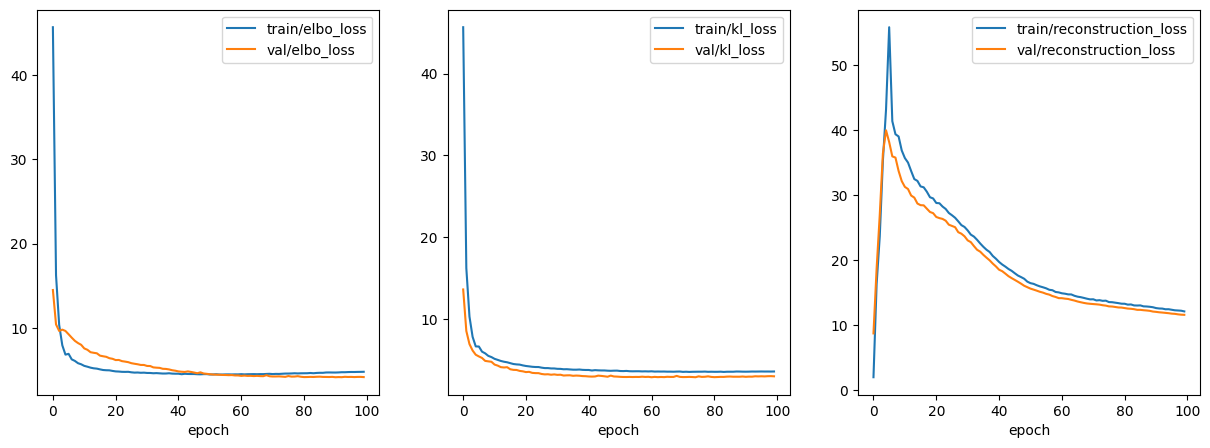

In [17]:
##### DO NOT CHANGE #####
# ID: training_disabled0 - possible points: 0

# Hidden test to check if do_training is set to False

if do_training == True:
    trainer.fit(ANORMALY_DETECTOR, DATA_MODULE)
    plot_logged_metrics(trainer, metrics=list(ANORMALY_DETECTOR_METRICS.keys()))

##### DO NOT CHANGE #####

## 1.4 Testing the model

We now test the model capability to be able to detect the abnormal ECGs and how well it can reconstruct given ECGs. Therefore the testing process outputs the following graphs:

1. few examples of reconstruction of test data
2. distribution of reconstruction errors on training set and 0.85 quantile in red
3. distribution of reconstruction errors on test set, separately for the 2 classes (threshold in red)
4. confusion matrix associated to our detector

Additionally three measures were computed to evaluate our classifier: precision, recall and F1 score.

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

 Avg reconstruction error 
 	 normal data : 2.8746252059936523, anomalies : 8.196316719055176
Quality measures of our classifier:
	 precision : 0.8746177370030581
	 recall : 0.9152
	 F1_score : 0.8944487881157154


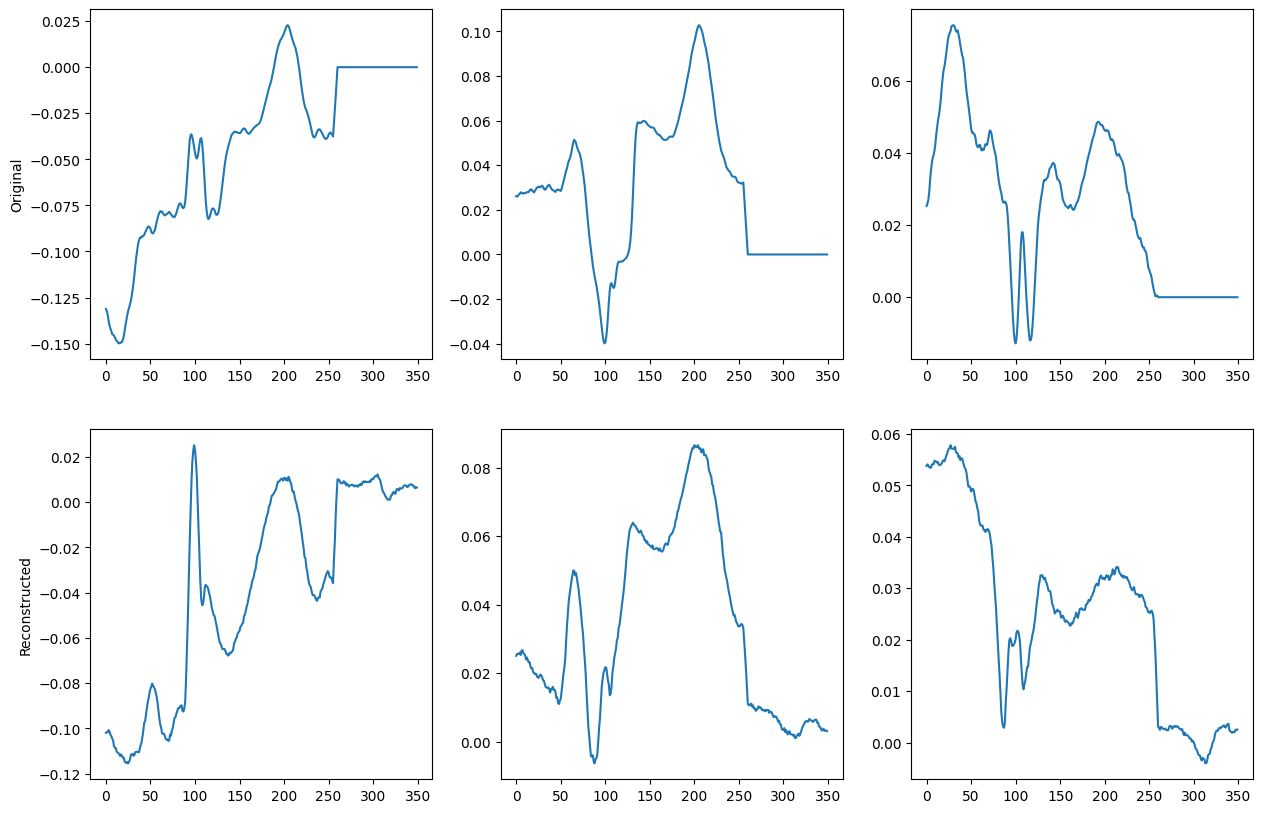

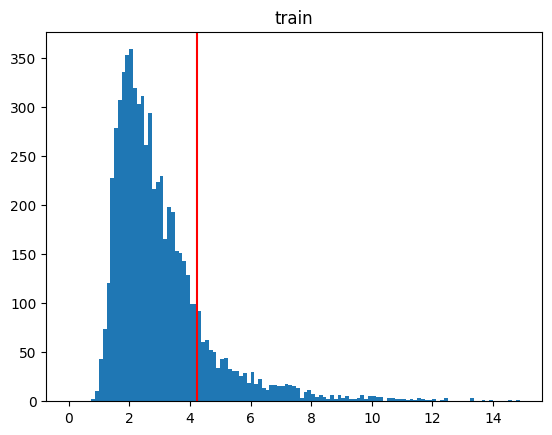

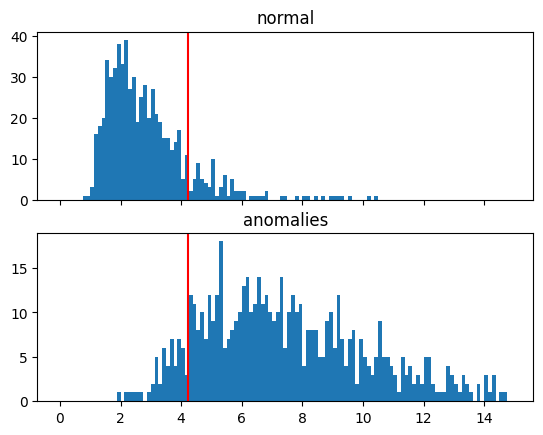

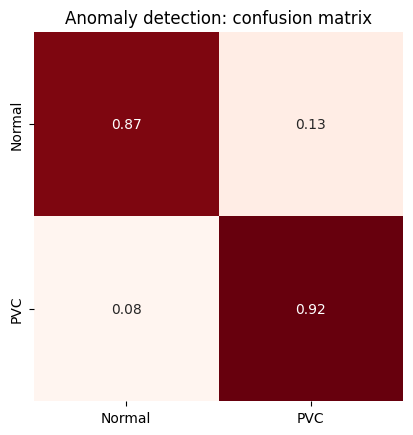

In [18]:
##### DO NOT CHANGE #####
out = trainer.test(
    ANORMALY_DETECTOR,
    dataloaders=[DATA_MODULE.train_dataloader(), DATA_MODULE.test_dataloader()],
)

##### DO NOT CHANGE #####

## 1.5 Uncertainty Estimation

A vantage of having a probabilistic representation of the encodings is that we can extract uncertainties over the reconstructed data. In the following cell we will perform a simple Monte Carlo evaluation of the uncertainties and plot confidence intervals around the mean reconstruction of the input.

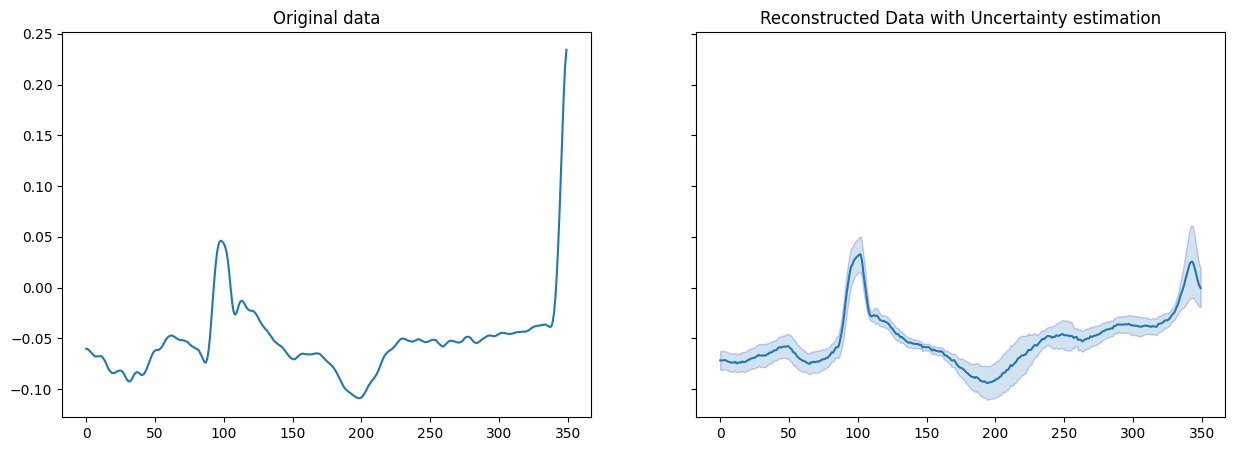

In [19]:
##### DO NOT CHANGE #####
def uncertainty_estimation():
    x, y = next(iter(DATA_MODULE.train_dataloader()))
    data = x[0]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
    ax0: Axes = ax[0]
    ax1: Axes = ax[1]
    ax0.plot(data)
    ax0.set_title("Original data")
    model = ANORMALY_DETECTOR.model

    model.eval()
    mean, logstd = model.encode(data)
    reconstructions: list[torch.Tensor] = []
    for i in range(10):
        z = model.reparameterize(mean, logstd)
        reconstructions.append(model.decode(z).unsqueeze(0))
    reconstructed: torch.Tensor = torch.cat(reconstructions, axis=0)
    mean = reconstructed.mean(axis=0).detach().numpy()
    std = reconstructed.std(axis=0).detach().numpy()
    ax1.plot(mean)
    ax1.fill_between(
        np.arange(350), mean + 2 * std, mean - 2 * std, alpha=0.2, edgecolor="blue"
    )

    ax1.set_title("Reconstructed Data with Uncertainty estimation")


uncertainty_estimation()

##### DO NOT CHANGE #####

## 1.6 Task: Generating new Data

VAEs can be used to generate new datapoints. Once the network has been trained, we can sample latent representations from the prior distribution (in our case a standard gaussian) and decode them to produce new unseen data. The same mechanism is at the base of GANs.

Produce new data yourself by completing the `generate_new_data` function.

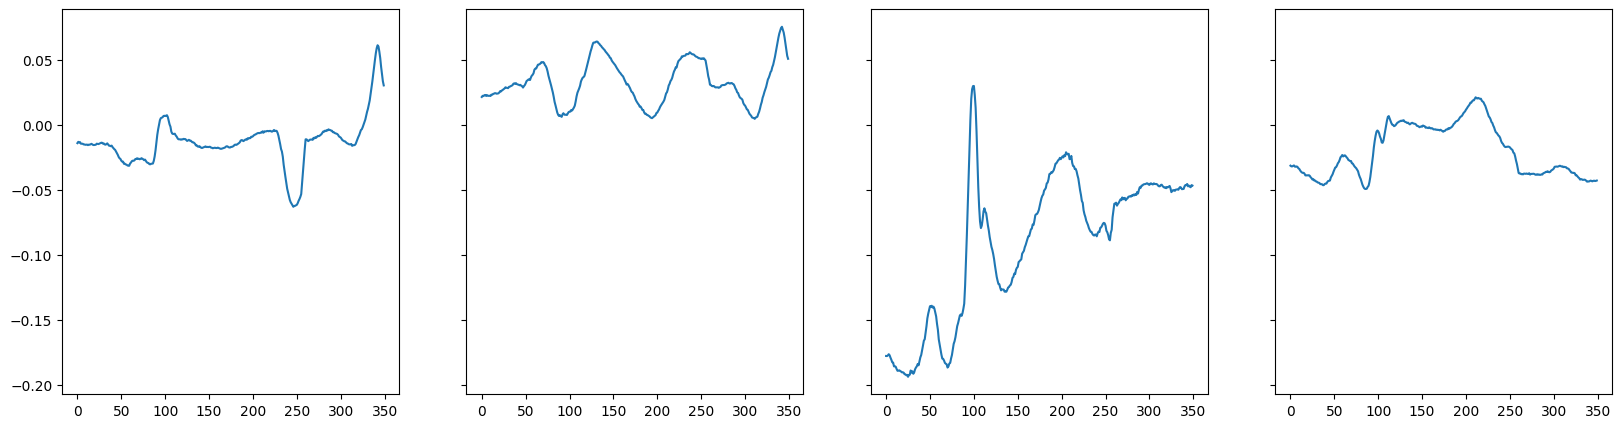

In [22]:
def generate_new_data() -> tuple[NDArray, torch.Tensor]:
    model = ANORMALY_DETECTOR.model
    model.eval()
    sample_size = model.embedding_dim
    sample = torch.randn(sample_size)  # TODO: sample from the prior (standard normal) use the sample_size
    new_data = model.decode(sample).detach().numpy()  # TODO: feed the sample to the decoder of the model to produce new data. Make sure to call .detach() on the output tensor and convert it to numpy
    # YOUR CODE HERE

    return new_data, sample


def plot_generated_data():
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
    for i in range(4):
        data, _ = generate_new_data()
        axs[i].plot(data)


plot_generated_data()

In [21]:
##### DO NOT CHANGE #####
# ID: Generate_new_data - possible points: 2

# 2 Point - Generate_new_data
# Public tests
def test_generate_new_data():
    new_data, sample = generate_new_data()
    assert isinstance(new_data, np.ndarray), "Generated data should be a numpy array"
    assert new_data.shape == (350,), "Generated data should have shape (350,)"
    assert isinstance(sample, torch.Tensor), "Sample should be a torch tensor"
    assert sample.shape == (30,), "Sample should have shape (30,)"


test_generate_new_data()
# Hidden test to check if generate_new_data works correctly

##### DO NOT CHANGE #####


# 2. Adding a Binary Classifier

We have seen the basic structure of a VAE, tested it on a anomaly detection task and seen how new data can be generated by means of the decoder. We will now see how we can enforce simple properties on the representations in the latent space.

By minimizing the KL we are forcing the representations (remember that these are distributions, not single values) produced by the encoder to be as close as possible to a standard normal. We could go beyond this and impose, for example, that the distributions of representations corresponding to different classes of data occupy distinct sub-volumes of the latent space.

Our training set will now consist of ECGs of both 'normal' and 'PVC' classes. We will train, in parallel to a standard VAE (as above), a linear classifier that takes in input the means of the distributions produced by the encoder and outputs if the datapoint is normal or an anomaly. In this way the means of the distributions corresponding to the two different classes will be pushed in linearly separable volumes of the latent space.

## 2.1 Task: Implementing the Binary Classifier
Implement a simple classifier of one single fully connected layer. Select the right activation function for a binary classifier (you have already encountered it in a previous exercise).

Hint: torch.nn module has useful functions...

In [23]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.fc = nn.Linear(input_dim,1)  # f(ully)c(onnected)
        self.activation = nn.Sigmoid()              # we need a differentiable function with codomain (0,1)...

        # YOUR CODE HERE

    def forward(self, data):
        return self.activation(self.fc(data))


class VAEWithIntegratedBC(nn.Module):
    def __init__(
        self,
        input_dim: int = 350,
        embedding_dim: int = 3,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vae = VAE(input_dim, embedding_dim)
        self.classifier = BinaryClassifier(embedding_dim)

    def forward(
        self,
        x: torch.Tensor,
    ) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        out, mean, logstd, z = self.vae(x)
        logits = self.classifier(mean).squeeze()
        return out, mean, logstd, z, logits

In [24]:
##### DO NOT CHANGE #####
# ID: Binary_classifier - possible points: 2

# hidden tests checking if the choice of layers is correct

##### DO NOT CHANGE #####

## 2.2 Task: Implementing the combined Loss
Try to implement the loss of our new architecture. It will have to be composed of the ELBOLoss we already implemented and an additional term regarding the classification task.

In [26]:
class ELBOLossWithBC(nn.Module):
    def __init__(self, kl_weight: float = 0.1):
        super().__init__()
        self.elbo_loss = ELBOLoss(kl_weight=kl_weight)
        self.classification_loss = nn.BCELoss()

    def forward(
        self,
        x: torch.Tensor,
        out: torch.Tensor,
        mean: torch.Tensor,
        logstd: torch.Tensor,
        logits: torch.Tensor,
        y: torch.Tensor,
        scaling: float = 1.0,
    ) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        """
        Computes the ELBO loss and an additional classification loss term.
        The reconstruction loss, KL divergence, and classification loss are computed
        and returned along with the reconstruction error.
        """
        elbo_loss, reconstruction_loss, kl_loss, reconstruction_error = (
            self.elbo_loss.forward(x, out, mean, logstd, scaling=scaling)
        )
        classification_loss = self.classification_loss(logits, y)  # TODO: please compute the classification loss here using the self.classification_loss attribute
        # YOUR CODE HERE

        total_loss = elbo_loss + classification_loss
        return (
            total_loss,
            elbo_loss,
            reconstruction_loss,
            kl_loss,
            classification_loss,
            reconstruction_error,
        )


In [28]:
##### DO NOT CHANGE #####
# ID: ELBoLossWithBC - possible points: 2

# Public tests
def test_ELBOLossWithBC():
    loss_fn = ELBOLossWithBC(kl_weight=0.1)
    x = torch.randn(10, 350)
    out = torch.randn(10, 350)
    mean = torch.randn(10, 3)
    logstd = torch.randn(10, 3)
    logits = torch.sigmoid(torch.randn(10, 1)).squeeze()
    y = torch.randint(0, 2, (10,))

    (
        total_loss,
        elbo_loss,
        reconstruction_loss,
        kl_loss,
        classification_loss,
        reconstruction_error,
    ) = loss_fn(x, out, mean, logstd, logits, y.float())

    assert isinstance(elbo_loss, torch.Tensor), "ELBO loss should be a tensor"
    assert isinstance(classification_loss, torch.Tensor), (
        "Classification loss should be a tensor"
    )


test_ELBOLossWithBC()


# Hidden tests to check if the ELBOLossWithBC works correctly

##### DO NOT CHANGE #####

## 2.3 Adjusting the training and testing pipeline

Since our model now also produces a prediction as an output we have to account for that in our training and testing pipeline. In the following cell we define a new `LightningModule` that inherits from the one we already defined above to be able to reuse some functionality. We only redfine wwhich needs to be redefined in order to account for the additional model output.

In [29]:
##### DO NOT CHANGE #####
class VAEWithIntegratedBCLitModule(VAELitModule):
    def __init__(
        self,
        metrics: MetricCollection,
    ):
        super().__init__(metrics=metrics)
        self.model = VAEWithIntegratedBC(input_dim=350, embedding_dim=3)
        self.loss = ELBOLossWithBC(kl_weight=0.1)

        self.test_labels = []
        self.test_predictions = []
        self.test_means = []

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.model(x)

    def _step(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        metrics: MetricCollection | None = None,
        reconstruction_errors: list | None = None,
        kl_scaling: float = 1.0,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x, y = batch
        out, mean, logstd, z, logits = self(x)
        *loss_terms, reconstruction_error = total_loss, *_ = self.loss.forward(
            x,
            out,
            mean,
            logstd,
            logits,
            y.float(),
            scaling=kl_scaling,
        )

        if metrics is not None:
            for loss, metric in zip(loss_terms, metrics.values()):
                metric.update(loss)

        if reconstruction_errors is not None:
            reconstruction_errors.append(reconstruction_error.detach().cpu())

        return total_loss, out

    def test_step(
        self,
        batch: tuple[torch.Tensor, torch.Tensor],
        batch_idx: int,
    ):
        x, y = batch
        out, mean, *_, logits = self.forward(x)
        self.test_labels.append(y.detach().cpu())
        self.test_predictions.append((logits > 0.5).float().detach().cpu())
        self.test_means.append(mean.detach().cpu())

        if batch_idx == 0:
            plot_reconstructed(original=x, reconstructed=out, n_samples=3)

    def on_test_end(self):
        labels = torch.cat(self.test_labels).numpy().astype("int")
        preds = torch.cat(self.test_predictions).numpy().astype("int")

        fig, ax = plt.subplots()
        cm = confusion_matrix(labels, preds, normalize="true")
        sns.heatmap(
            cm,
            square=True,
            xticklabels=["Normal", "PVC"],
            yticklabels=["Normal", "PVC"],
            annot=True,
            cbar=False,
            cmap="Reds",
            fmt=".2f",
        ).get_figure()
        ax.set_title("Classification: confusion matrix")

        means = torch.cat(self.test_means).numpy()
        colors = {0: "blue", 1: "red"}
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.scatter(
            means[:, 0],
            means[:, 1],
            means[:, 2],
            marker=".",
            s=20,
            c=[colors[i] for i in labels],
        )
        ax.set_title("Latent space")
        ax.set_xlim(-4.0, 4.0)
        ax.set_ylim(-4.0, 4.0)
        ax.set_zlim(-4.0, 4.0)

##### DO NOT CHANGE #####

## 2.4 Training the model

We will now train our network for a cycle of 100 epochs. As an out we will agains how the different loss curves.

In [30]:
##### DO NOT CHANGE #####
trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    devices=1,
    accelerator="cpu",
    logger=CSVLogger("logs", name="VAE_BC_ECG"),
)

BC_METRICS = MetricCollection(
    {
        "elbo_loss": MeanMetric(),
        "reconstruction_loss": MeanMetric(),
        "kl_loss": MeanMetric(),
        "classification_loss": MeanMetric(),
    }
)

BC_VAE = VAEWithIntegratedBCLitModule(
    metrics=BC_METRICS,
)

DATA_MODULE.composed = True

##### DO NOT CHANGE #####

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


**Please set `do_training`to `False` for the submission of your sheet!**

In [31]:
do_training = False
# YOUR CODE HERE


INFO: 
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | VAEWithIntegratedBC | 355 K  | train
1 | loss          | ELBOLossWithBC      | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | val_metrics   | MetricCollection    | 0      | train
--------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.423     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | VAEWithIntegratedBC | 355 K  | train
1 | loss          | ELBOLossWithBC      | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | val_metrics   | MetricCollection    | 0      |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


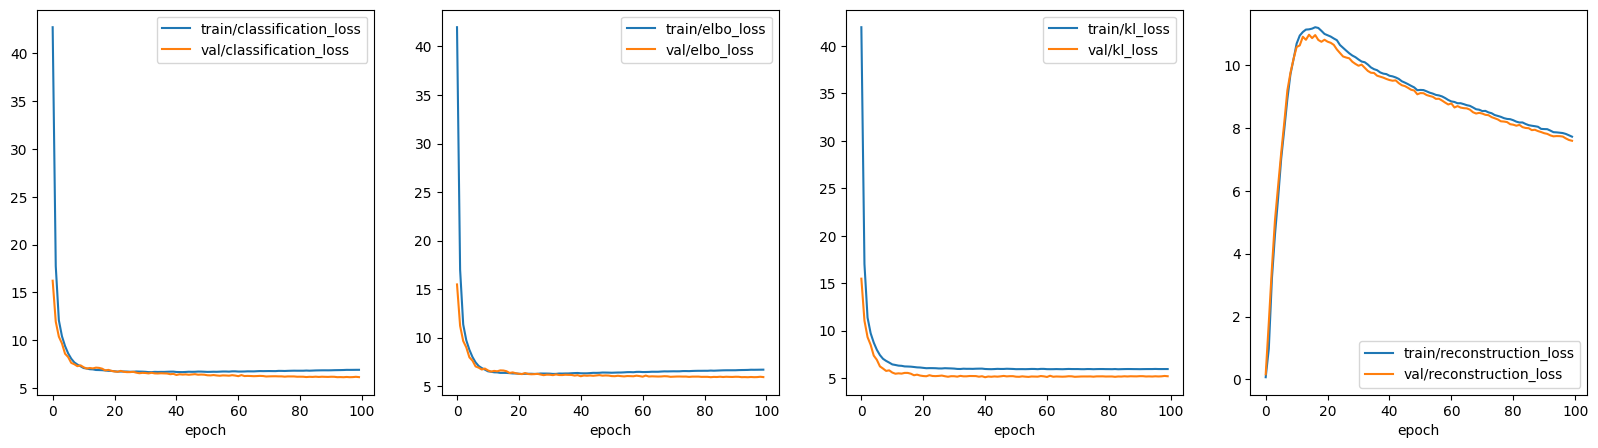

In [32]:
##### DO NOT CHANGE #####
# ID: training_disabled1 - possible points: 0

# Hidden test to check if do_training is set to False

if do_training == True:
    trainer.fit(BC_VAE, DATA_MODULE)
    plot_logged_metrics(trainer, metrics=list(BC_METRICS.keys()))

##### DO NOT CHANGE #####

## 2.5 Testing the model

As we successfully trained our model it is time to test it. For convenience we directly output the following
1. confusion matrix associated to the binary classifier
2. interactive 3D graph in the latent space of the means of the representation distributions produced by the encoder on the test set, where blue points are 'normal' and red points are 'PVC' ECGs.

Testing: |          | 0/? [00:00<?, ?it/s]

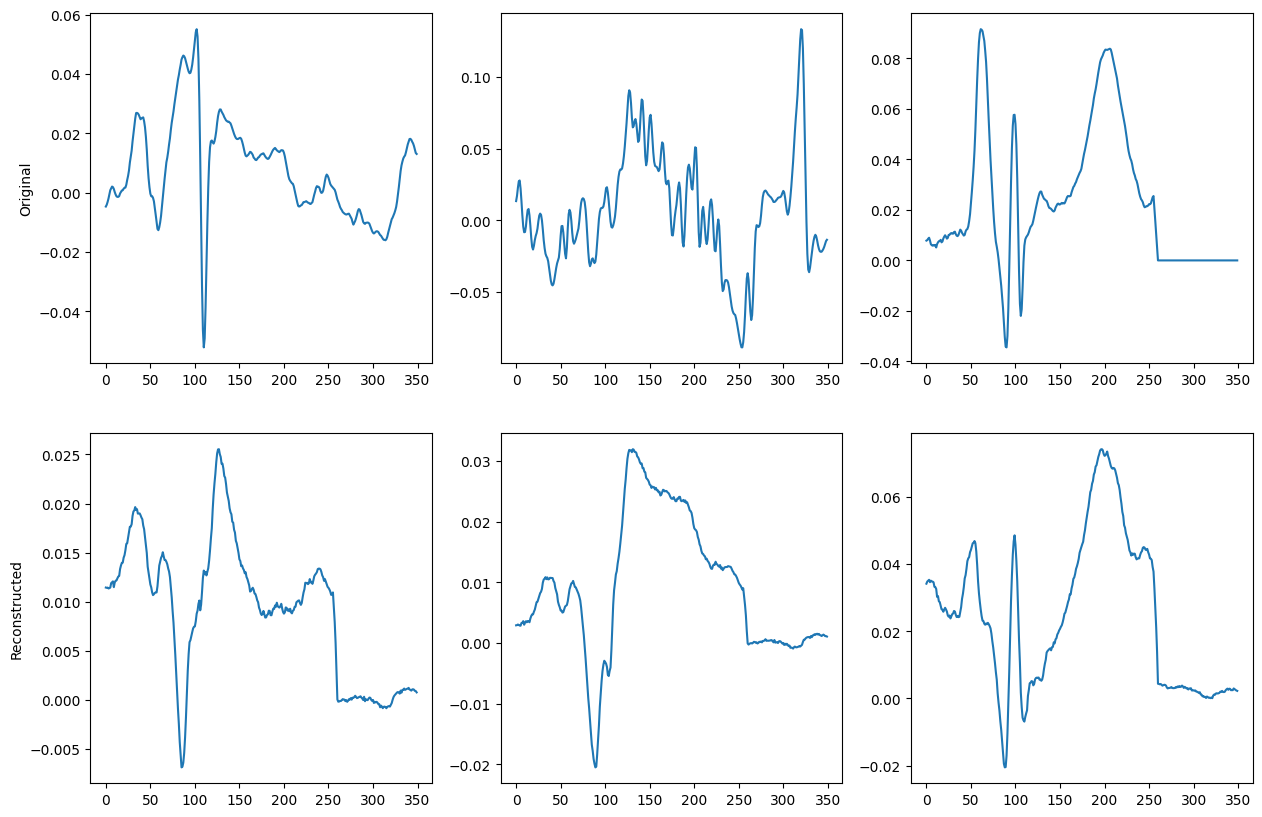

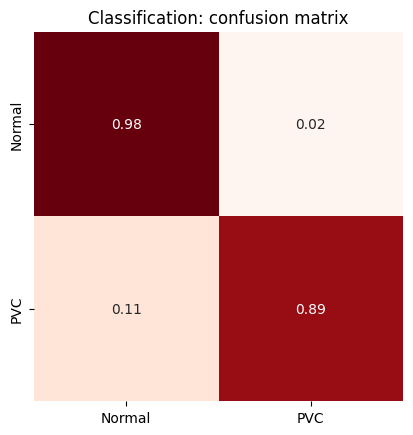

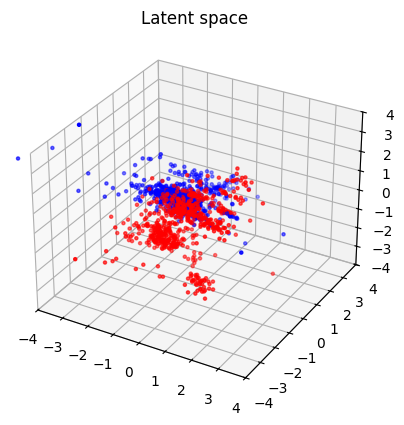

In [33]:
##### DO NOT CHANGE #####
out = trainer.test(BC_VAE, DATA_MODULE)

##### DO NOT CHANGE #####

Lets finally produce two ECGs corresponding to the two different classes 'normal' and 'PVC'.

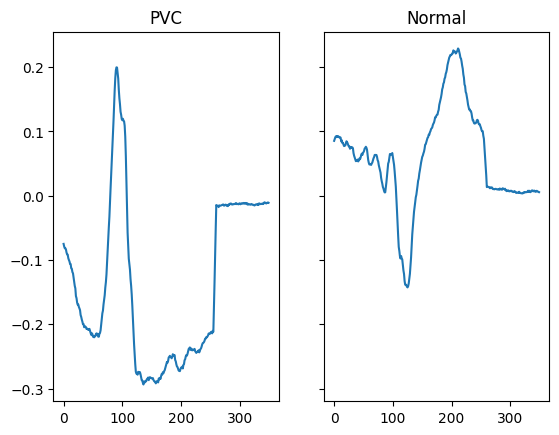

In [34]:
##### DO NOT CHANGE #####
def plot_decoded_classes():
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    embs = torch.tensor([[0.0, 0.0, -3.0], [0.0, 0.0, 3.0]])
    classes = ["Normal", "PVC"]
    model = BC_VAE.model
    model.eval()
    for i in range(2):
        new_data = model.vae.decode(embs[i]).detach().numpy()
        axs[i].plot(np.arange(350), new_data)
        c = int((model.classifier(embs[i]).detach().numpy() > 0.5)[0])
        axs[i].set_title(classes[c])


plot_decoded_classes()

##### DO NOT CHANGE #####